# About
### Author:
    Thiago Luis Rodrigues Pinho @AILAB 
### Start Date:
    16/04/2020
### Objectives:
    Develop a clustering algorithm using k-means and represent those cluster distances for ALEI project
### Summary:
    1. Loading Data
        1.1 Sampling Data
    2. Counting and Vectorizing
    3. Clustiring with k-means
        3.1 Finding the optimal number of clusters
        3.2 Evaluting the optimal number of clusters
    4. Bibliography

# [ALEI] IAgrupador com Cluster

In [1]:
from time import time

import spacy
from spacy.lang.pt.stop_words import STOP_WORDS
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from fastparquet import write
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('fivethirtyeight')

## 1. Loading data

In [3]:
%%time 
RELATIVE_FOLDER_PATH = "./data/"
VECTOR_MODEL_NAME = "pt_core_news_sm"
NLP_SPACY = spacy.load(VECTOR_MODEL_NAME)
filename = "data_preprocessed"
stopwords_set = set(STOP_WORDS)

parquet_filename = RELATIVE_FOLDER_PATH + filename + ".parquet.gzip"
ailab_df = pd.read_parquet(parquet_filename, columns=['process_class', 'text', 'process_id'])
print(ailab_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2036 entries, 0 to 2035
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  2036 non-null   object
 1   text           2036 non-null   object
 2   process_id     2036 non-null   object
dtypes: object(3)
memory usage: 47.8+ KB
None
CPU times: user 4.84 s, sys: 267 ms, total: 5.11 s
Wall time: 5.11 s


### 1.1  Sampling data
As some text processement can take a long time, it's good to only process the necessary amount

In [4]:
sample_df = ailab_df.sample(n=len(ailab_df))
print(sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 500 to 1492
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   process_class  2036 non-null   object
 1   text           2036 non-null   object
 2   process_id     2036 non-null   object
dtypes: object(3)
memory usage: 63.6+ KB
None


## 2. Counting and Vectorizing

In [5]:
%%time
tokenizer = NLP_SPACY.Defaults.create_tokenizer(NLP_SPACY)
raw_text = sample_df['text'].to_list()

tokenized_text = []
for row in raw_text:
    doc = tokenizer(row)
    preprocessed_doc = [token for token in doc if not token.norm_ in stopwords_set]
    tokenized_text.append(" ".join([word.text for word in preprocessed_doc]))

count_vectorizer = CountVectorizer()
tfidf_transformer = TfidfTransformer()

''' Encapsuling components in pipeline '''
pipeline = Pipeline([
    ('count_vectorizer', count_vectorizer),
    ('tfidf_transformer', tfidf_transformer)
])

vectorized_docs = pipeline.fit_transform(tokenized_text)

CPU times: user 22.5 s, sys: 33.9 ms, total: 22.5 s
Wall time: 22.5 s


## 3. Clustering with k-means

### 3.1 Finding the optimal number of clusters
To find it, let's use the elbow curve analysis. In this analysis we try models from an interval of cluster numbers and using each model's cluster cohesion to score them. 

In [6]:
number_clusters = range(1, 7)

kmeans = [KMeans(n_clusters=i, max_iter = 600) for i in number_clusters]
print(kmeans)

[KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=1, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=600,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0), KMeans(algorithm='auto', copy

In [7]:
score = [kmeans[i].fit(vectorized_docs).score(vectorized_docs) for i in range(len(kmeans))]
print(score)

[-1910.7084581686267, -1775.4148077577634, -1750.8698803897714, -1722.5105439059994, -1699.7566513534928, -1674.7518182930494]


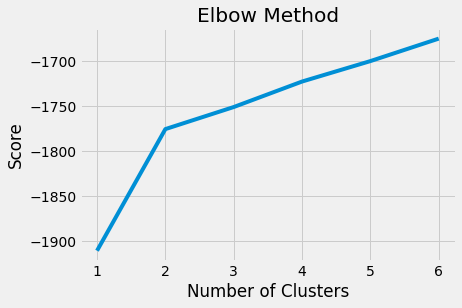

In [8]:
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

### 3.2 Evaluting the optimal number of clusters
On the last step we saw how after 3 cluster the improving in score slows down how much it changes.
Let's choose 3 then.

In [19]:
sklearn_SVD = TruncatedSVD(n_components = 2)
svd_docs = sklearn_SVD.fit_transform(vectorized_docs)
kmeans = KMeans(n_clusters=3, max_iter=600, algorithm = 'auto')
fitted = kmeans.fit(svd_docs)
prediction = kmeans.predict(svd_docs)

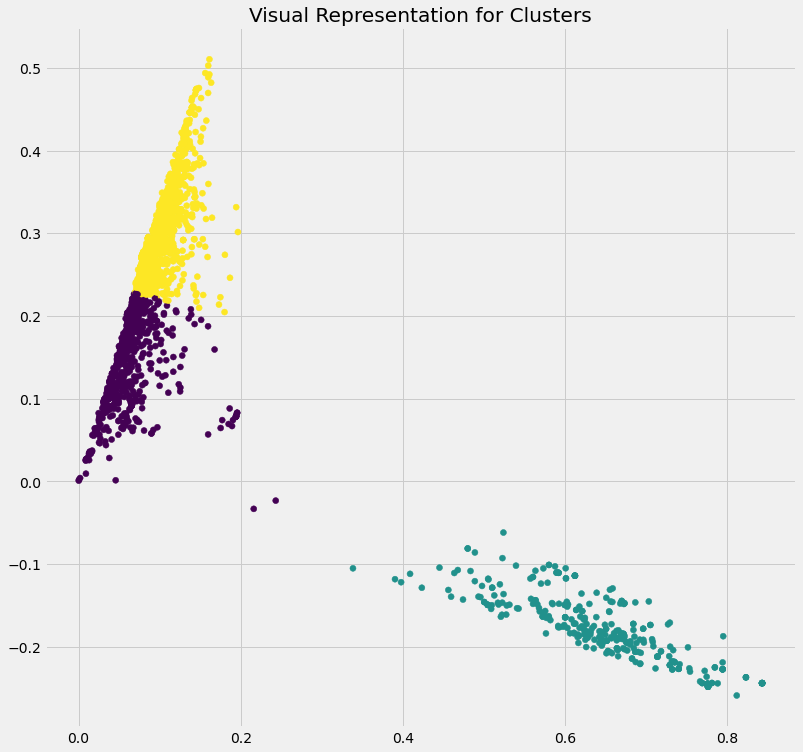

In [20]:
fig = plt.figure(figsize=(12, 12))
plt.scatter(svd_docs[:, 0], svd_docs[:, 1], c=prediction)
plt.title("Visual Representation for Clusters")

plt.show()

## 4. Bibliography

K-Means Clustering. Daniel Furlay. [Avaiablae at](https://towardsdatascience.com/k-means-clustering-8e1e64c1561c) Last visited: 16/04/2020